Reference: 

- https://www.kaggle.com/code/armanasgharpoor1993/coco-dataset-tutorial-image-segmentation

- https://github.com/tkshnkmr/frcnn_medium_sample

In [1]:
import os
import pathlib
import matplotlib.pyplot as plt
from PIL import Image

from pycocotools.coco import COCO

import torch
from torch import nn
import torch.ao.quantization as tq
import torch.utils.data
import torchvision as tv
import torchvision.transforms as T
import onnxruntime

from ubervvald.DNAS import prepare_NAS, NASConfig, NAS_train, NAS_finetune
from ubervvald.quant import prepare_quantize, quantize


from MobileNetV1 import MobileNetV1

if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [2]:
dataDir='dataset/coco2014/'
dataType='val2014'
annFile='{}annotations/instances_{}.json'.format(dataDir,dataType)
imageDir = '{}/images/{}/'.format(dataDir, dataType)

# Initialize the COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=4.89s)
creating index...
index created!


In [3]:
# Load categories for the given ids
ids = 1
cats = coco.loadCats(ids=ids)
print(cats)

[{'supercategory': 'person', 'id': 1, 'name': 'person'}]


In [4]:
category_ids = coco.getCatIds()
num_categories = len(category_ids)
print('number of categories: ',num_categories)
ptId = 0
ptDict = dict()
for ids in category_ids:
    cats = coco.loadCats(ids=ids)
    # print(cats[0])
    ptDict[cats[0]['id']] = ptId
    ptId += 1

number of categories:  80


In [5]:
# Load images for the given ids
image_ids = coco.getImgIds() # you can also download them via coco.download(dict["flick_url"])
image_id = image_ids  # Change this line to display a different image
image_info = coco.loadImgs(image_id)
# for info in image_info:
    # print(info)# Load annotations for the given ids
annotation_ids = coco.getAnnIds(imgIds=image_id)
annotations = coco.loadAnns(annotation_ids)
for ann in annotations[:20]:
    print(ann)# Load annotations for the given ids
# print(annotations)

{'segmentation': [[376.97, 176.91, 398.81, 176.91, 396.38, 147.78, 447.35, 146.17, 448.16, 172.05, 448.16, 178.53, 464.34, 186.62, 464.34, 192.28, 448.97, 195.51, 447.35, 235.96, 441.69, 258.62, 454.63, 268.32, 462.72, 276.41, 471.62, 290.98, 456.25, 298.26, 439.26, 292.59, 431.98, 308.77, 442.49, 313.63, 436.02, 316.86, 429.55, 322.53, 419.84, 354.89, 402.04, 359.74, 401.24, 312.82, 370.49, 303.92, 391.53, 299.87, 391.53, 280.46, 385.06, 278.84, 381.01, 278.84, 359.17, 269.13, 373.73, 261.85, 374.54, 256.19, 378.58, 231.11, 383.44, 205.22, 385.87, 192.28, 373.73, 184.19]], 'area': 12190.44565, 'iscrowd': 0, 'image_id': 391895, 'bbox': [359.17, 146.17, 112.45, 213.57], 'category_id': 4, 'id': 151091}
{'segmentation': [[352.55, 146.82, 353.61, 137.66, 356.07, 112.66, 357.13, 94.7, 357.13, 84.49, 363.12, 73.92, 370.16, 68.64, 370.16, 66.53, 368.4, 63.71, 368.05, 54.56, 361.0, 53.85, 356.07, 50.33, 356.43, 46.46, 364.17, 42.23, 369.1, 35.89, 371.22, 30.96, 376.85, 26.39, 383.54, 22.16, 39

In [6]:
# Load images for the given ids
image_ids = coco.getImgIds() # you can also download them via coco.download(dict["flick_url"])
image_id = image_ids[0]  # Change this line to display a different image
image_info = coco.loadImgs(image_id)
print(image_info)

[{'license': 3, 'file_name': 'COCO_val2014_000000391895.jpg', 'coco_url': 'http://images.cocodataset.org/val2014/COCO_val2014_000000391895.jpg', 'height': 360, 'width': 640, 'date_captured': '2013-11-14 11:18:45', 'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg', 'id': 391895}]


In [7]:
# Load annotations for the given ids
annotation_ids = coco.getAnnIds(imgIds=image_id)
annotations = coco.loadAnns(annotation_ids)
print(annotations)

[{'segmentation': [[376.97, 176.91, 398.81, 176.91, 396.38, 147.78, 447.35, 146.17, 448.16, 172.05, 448.16, 178.53, 464.34, 186.62, 464.34, 192.28, 448.97, 195.51, 447.35, 235.96, 441.69, 258.62, 454.63, 268.32, 462.72, 276.41, 471.62, 290.98, 456.25, 298.26, 439.26, 292.59, 431.98, 308.77, 442.49, 313.63, 436.02, 316.86, 429.55, 322.53, 419.84, 354.89, 402.04, 359.74, 401.24, 312.82, 370.49, 303.92, 391.53, 299.87, 391.53, 280.46, 385.06, 278.84, 381.01, 278.84, 359.17, 269.13, 373.73, 261.85, 374.54, 256.19, 378.58, 231.11, 383.44, 205.22, 385.87, 192.28, 373.73, 184.19]], 'area': 12190.44565, 'iscrowd': 0, 'image_id': 391895, 'bbox': [359.17, 146.17, 112.45, 213.57], 'category_id': 4, 'id': 151091}, {'segmentation': [[352.55, 146.82, 353.61, 137.66, 356.07, 112.66, 357.13, 94.7, 357.13, 84.49, 363.12, 73.92, 370.16, 68.64, 370.16, 66.53, 368.4, 63.71, 368.05, 54.56, 361.0, 53.85, 356.07, 50.33, 356.43, 46.46, 364.17, 42.23, 369.1, 35.89, 371.22, 30.96, 376.85, 26.39, 383.54, 22.16, 

In [8]:
# Get category ids that satisfy the given filter conditions
filterClasses = ['laptop', 'tv', 'cell phone']
# Fetch class IDs only corresponding to the filterClasses
catIds = coco.getCatIds(catNms=filterClasses)
print(catIds)

# Load category information for the given ID
catID = 15
print(coco.loadCats(ids=catID))

# Get image ID that satisfies the given filter conditions
imgId = coco.getImgIds(catIds=[catID])
print(imgId)
imgId = imgId[0]
ann_ids = coco.getAnnIds(imgIds=[imgId], iscrowd=None)
print(ann_ids)

[72, 73, 77]
[{'supercategory': 'outdoor', 'id': 15, 'name': 'bench'}]
[262148, 311309, 458768, 253969, 434204, 253986, 180261, 270376, 270381, 73773, 254001, 319541, 548939, 163929, 573536, 73830, 565353, 540782, 540783, 450674, 385139, 147576, 516224, 131207, 123017, 106641, 360595, 524436, 8351, 450724, 417957, 344229, 24744, 385194, 254123, 385196, 368820, 467130, 204994, 319687, 262347, 467151, 188624, 327890, 139475, 385238, 16599, 262360, 426203, 147681, 295138, 336101, 434410, 8188, 90349, 565485, 172271, 180463, 278771, 196852, 516342, 8445, 82174, 57597, 246014, 303365, 442630, 475407, 377111, 352538, 172319, 49444, 352552, 385322, 180524, 57645, 246066, 368949, 221502, 188735, 115006, 516415, 516422, 328, 328008, 123213, 33104, 221521, 336209, 33116, 188766, 237920, 385378, 549220, 295270, 221547, 409963, 213356, 360818, 139637, 491902, 115070, 459136, 90501, 475529, 8589, 459153, 573843, 106901, 98716, 385438, 237984, 131493, 418219, 328110, 205232, 475572, 41397, 565693, 2

Annotations for Image ID 262148:
COCO_val2014_000000262148.jpg


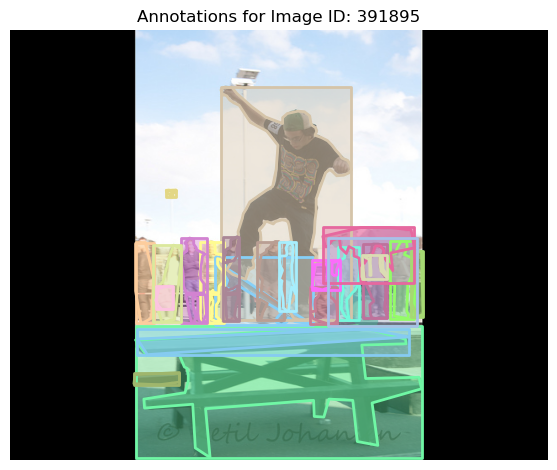

In [9]:
print(f"Annotations for Image ID {imgId}:")
anns = coco.loadAnns(ann_ids)

image_path = coco.loadImgs(imgId)[0]['file_name']
print(image_path)
image = plt.imread(imageDir + image_path)
plt.imshow(image)

# Display the specified annotations
coco.showAnns(anns, draw_bbox=True)

plt.axis('off')
plt.title('Annotations for Image ID: {}'.format(image_id))
plt.tight_layout()
plt.show()

In [10]:
class cocoPTDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.catIds = self.coco.getCatIds()
        self.catFrq = torch.Tensor([len(self.coco.getImgIds()) - len(self.coco.getImgIds(catIds=1)), len(self.coco.getImgIds(catIds=1))])
        # derive corresponding loss weights as w_class_i = tot_windows / class_i_windows
        self.catWeights = torch.Tensor([len(self.coco.getImgIds())]) / self.catFrq

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]["file_name"]
        # open the input image
        img = Image.open(os.path.join(self.root, path))

        catIds = [ann["category_id"] for ann in coco_annotation]
        labels = torch.Tensor([0, 1] if 1 in catIds else [1,0]) 

        if self.transforms is not None:
            img = self.transforms(img)

        return img, labels

    def __len__(self):
        return len(self.ids)

imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # mean and std values of the Imagenet Dataset so that pretrained models could also be used


#setting a set of transformations to transform the images 
transform= T.Compose([T.Resize((96, 96)),
                      T.Grayscale(3),
                    #   T.RandomCrop(128),
                      T.RandomHorizontalFlip(),
                      T.RandomRotation(2),
                      T.ToTensor(),
                      T.Normalize(*imagenet_stats)])

# collate_fn needs for batch
# def collate_fn(batch):
#     return tuple(zip(*batch))


In [11]:
classes = open("coco.names", "r").read().splitlines()
print(classes)
train_ds = cocoPTDataset("dataset/coco2014/images/train2014/", "dataset/coco2014/annotations/instances_train2014.json", transforms = transform)
val_ds = cocoPTDataset("dataset/coco2014/images/val2014/", "dataset/coco2014/annotations/val.json", transforms = transform)
test_ds = cocoPTDataset("dataset/coco2014/images/val2014/", "dataset/coco2014/annotations/test.json", transforms = transform)
len(train_ds), len(test_ds), len(val_ds)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
loading annotations into memory...
Done (t=11.57s)
creating index...
index created!
loading annotations into memory...
Done (t=4.73s)


(82783, 23648, 36312)

In [13]:
def denorm(img_tensors): #this function will denormalize the tensors 
    return img_tensors * imagenet_stats[1][0] + imagenet_stats[0][0]

def show_example(img,label):
  plt.imshow(denorm(img).permute(1,2,0))
  print("Label:", label)
  print()
  print(label)
# show_example(*train_ds[11380]) #let's take an example

In [ ]:
model = MobileNetV1(n_classes=2, quantize=False, depth_multiplier=.25, use_relu6=False)
print(model)

@NASConfig
def crit(train_ds):
    if "dataset" in dir(train_ds):
        train_ds = train_ds.dataset
        
    w = train_ds.catWeights.detach().clone()
    # create an instance of the torch.nn.CrossEntropyLoss with weight and label_smoothing and return it 
    crit = torch.nn.BCELoss(weight=w.to(NASConfig.get_device()))
    return crit

#@NASConfig
# def optimizer(model):
#     # Set up custom optimizer with weight decay
#     optim = opt_func(model.parameters(), lr=NASConfig.get_net_lr(), weight_decay=NASConfig.get_weight_decay())
#     # Set up one-cycle learning rate scheduler
#     # sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader)) #schedule the learning rate with OneCycleLR
#     return optim

#@NASConfig
# def nas_opt(model):
#     net_optim = opt_func(model.parameters(), lr=NASConfig.get_net_lr(), weight_decay=NASConfig.get_weight_decay())
#     nas_optim = opt_func(model.parameters(), lr=NASConfig.get_nas_lr())
#     return net_optim, nas_optim


TRAINING_CONFIG = {
    'model_dir': pathlib.Path("experiments/mobilenetv1/nas_model/"),
    'epochs': 150,
    'batch_size': 1024,
    'learning_rate': 0.0001,
    'nas_learning_rate': 0.0005,
    'label_smoothing': 0.25,
    'weight_decay':1e-4,
    'patience': 20,
    'reg_strengths': [1e-7, 0],
    'criterion': crit,
    "last_layer_activation": torch.nn.functional.softmax,
    # 'optimizer': optimizer,
    'num_classes': len(classes),
    'qat_qconfig': tq.get_default_qat_qconfig(backend='x86', version=1),
    # 'nas_optimizer':nas_opt,
    'isMultilabel' : True,
    'isGPU': True,
}

MobileNetV1(
  (model): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): DepthwiseSepConvBlock(
      (depthwise_conv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8)
      (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (pointwise_conv): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
    )
    (2): DepthwiseSepConvBlock(
      (depthwise_conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (pointwise_conv): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
    )
    (3): D

In [15]:
prepare_NAS(TRAINING_CONFIG)
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# model = NAS_train(model, train_ds, val_ds, test_ds)
model = NAS_finetune(model, train_ds, val_ds, test_ds)


Working on: cuda:0
Epoch: 1, Loss: 1.39, Acc: 0.55, Macro Acc: 0.55 Val Loss: 1.41, Val Acc: 0.52, Val Macro Acc: 0.52
Epoch: 2, Loss: 1.38, Acc: 0.56, Macro Acc: 0.56 Val Loss: 1.40, Val Acc: 0.53, Val Macro Acc: 0.53
Epoch: 3, Loss: 1.38, Acc: 0.56, Macro Acc: 0.56 Val Loss: 1.40, Val Acc: 0.53, Val Macro Acc: 0.53
Epoch: 4, Loss: 1.38, Acc: 0.56, Macro Acc: 0.56 Val Loss: 1.40, Val Acc: 0.54, Val Macro Acc: 0.54
Epoch: 5, Loss: 1.38, Acc: 0.56, Macro Acc: 0.56 Val Loss: 1.40, Val Acc: 0.54, Val Macro Acc: 0.54
Epoch: 6, Loss: 1.38, Acc: 0.56, Macro Acc: 0.56 Val Loss: 1.39, Val Acc: 0.54, Val Macro Acc: 0.54
Epoch: 7, Loss: 1.37, Acc: 0.57, Macro Acc: 0.57 Val Loss: 1.40, Val Acc: 0.54, Val Macro Acc: 0.54
Epoch: 8, Loss: 1.37, Acc: 0.57, Macro Acc: 0.57 Val Loss: 1.40, Val Acc: 0.54, Val Macro Acc: 0.54
Epoch: 9, Loss: 1.37, Acc: 0.57, Macro Acc: 0.57 Val Loss: 1.39, Val Acc: 0.54, Val Macro Acc: 0.54
Epoch: 10, Loss: 1.37, Acc: 0.57, Macro Acc: 0.57 Val Loss: 1.40, Val Acc: 0.55,

In [15]:
model = torch.load("experiments/mobilenetv1/nas_model/final_model_1e-07.pt")
config = {
    'arch': 'mobilenetv1',
    'quant_format': onnxruntime.quantization.QuantFormat.QOperator,
    'quant_w_type': onnxruntime.quantization.QuantType.QInt8,
    'quant_a_type': onnxruntime.quantization.QuantType.QUInt8,
    'batch_size': 1,
    'model_dir': 'experiments/mobilenetv1/quant_models/',
    'last_layer_activation': torch.nn.functional.sigmoid,
    'isGPU': False,
}
prepare_quantize(model, config)
quantize(test_ds)

ONNX num_of_params:  133,814
qONNX num_of_params:  133,932
Evaluating TorchScript


100%|##########| 500/500 [00:06<00:00, 74.67batches/s]


Avg elapsed time SAMPLE per batch  120.656
F1-score SAMPLE:  tensor(0.5967)
Hamming-score SAMPLE:  tensor(0.5860)

Evaluating ONNX


100%|##########| 500/500 [00:04<00:00, 101.62batches/s]


Avg elapsed time SAMPLE per batch  26.766
F1-score SAMPLE:  tensor(0.6207)
Hamming-score SAMPLE:  tensor(0.6090)

Evaluating qONNX


100%|##########| 500/500 [00:04<00:00, 107.05batches/s]

Avg elapsed time SAMPLE per batch  12.354
F1-score SAMPLE:  tensor(0.5873)
Hamming-score SAMPLE:  tensor(0.5820)



If you intend to do measurements, it is recommended to restart the python kernel and run only until the configuration definition and the cell below.

In [15]:
model = torch.load("experiments/mobilenetv1/nas_model/final_model_SEED.pt")
config = {
    'arch': 'mobilenetv1',
    'quant_format': onnxruntime.quantization.QuantFormat.QOperator,
    'quant_w_type': onnxruntime.quantization.QuantType.QInt8,
    'quant_a_type': onnxruntime.quantization.QuantType.QUInt8,
    'batch_size': 1,
    'model_dir': 'experiments/mobilenetv1/quant_modelsSEED/',
    'last_layer_activation': torch.nn.functional.sigmoid,
    'isGPU': False,
}
prepare_quantize(model, config)
quantize(test_ds)

ONNX num_of_params:  210,850
qONNX num_of_params:  210,968
Evaluating TorchScript


100%|##########| 500/500 [00:06<00:00, 75.97batches/s]


Avg elapsed time SAMPLE per batch  115.994
F1-score SAMPLE:  tensor(0.1013)
Hamming-score SAMPLE:  tensor(0.4960)

Evaluating ONNX


100%|##########| 500/500 [00:05<00:00, 85.50batches/s]


Avg elapsed time SAMPLE per batch  35.04
F1-score SAMPLE:  tensor(0.1080)
Hamming-score SAMPLE:  tensor(0.4980)

Evaluating qONNX


100%|##########| 500/500 [00:04<00:00, 107.11batches/s]


Avg elapsed time SAMPLE per batch  13.266
F1-score SAMPLE:  tensor(0.1020)
Hamming-score SAMPLE:  tensor(0.4930)

